In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
from pathlib import Path

from loader.dataloader import DataLoader

DATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw"
METADATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/data.h5"
run_loader = DataLoader(DATA_DIR, METADATA_DIR)

### Randomly select a sample from the dataset


Sample: HS006


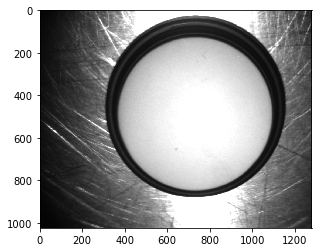

In [318]:
# rand_sample = random.randint(0, len(run_loader.samples) - 1)
# sample = run_loader.samples[rand_sample]
sample = run_loader.samples[5]
print(f"Sample: {sample.sample_id}")

# get white reference run
white_run = sample.whites[0]
white_img = white_run.get_spectral_image(wavelength=500)

fig, ax = plt.subplots()
ax.imshow(white_img, cmap="gray", vmin=0, vmax=255)
plt.show()

### Create Mask

No circle found, adjusting parameters


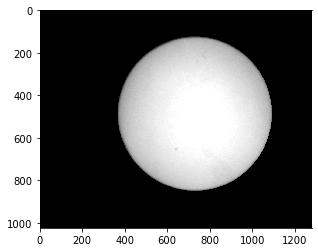

white value: 218.93700306105933


In [320]:
def find_circle(img, param1=100, param2=60, minRadius=0, maxRadius=0):
    return cv2.HoughCircles(
        img, cv2.HOUGH_GRADIENT, 1, 50, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius
    )

def get_mask(img):
    img_copy = img.copy()

    # img_copy = cv2.equalizeHist(img_copy)
    # circles = find_circle(img_copy)
    circles = None
    if circles is None:
        print("No circle found, adjusting parameters")

        img_copy = cv2.equalizeHist(img_copy)
        # _, img_copy = cv2.threshold(img_copy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # fig, ax = plt.subplots()
        # ax.imshow(img_copy, cmap="gray", vmin=0, vmax=255)
        # plt.show()

        # circles = find_circle(img_copy, param1=100, param2=18)
        circles = find_circle(img_copy, param1=100, param2=180)
        if circles is None:
            print("No circle found")
            raise SystemExit
        
    circles = np.uint16(np.around(circles))
    smallest = np.argmin(circles[0, :, 2])
    smallest = circles[0, smallest]

    mask = np.zeros_like(img_copy)
    cv2.circle(mask, (smallest[0], smallest[1]), smallest[2], 1, -1)

    return mask

mask = get_mask(white_img)
img_cp = white_img.copy()
img_cp[mask == 0] = 0

fig, ax = plt.subplots()
ax.imshow(img_cp, cmap="gray", vmin=0, vmax=255)
plt.show()

# get average of non-zero pixels
white_val = np.mean(img_cp[img_cp != 0])
print(f"white value: {white_val}")

### Adjust the hyperspectral image

In [321]:
def adjust_reflectance(sample):
    # get white reference
    white_run = sample.whites[0]
    white_ref = white_run.get_spectral_image(wavelength=500)

    # get mask
    mask = get_mask(white_ref)

    adjusted_runs = []
    for run in tqdm(sample.runs):
        adjusted_run = []
        for lm in range(440, 730, 10):
            try:
                # white reference
                white_img = white_run.get_spectral_image(wavelength=lm)
                white_img_cp = white_img.copy()
                # apply mask
                white_img_cp = white_img_cp * mask
                # get average of non-zero pixels
                # white_val = np.mean(white_img_cp[white_img_cp != 0])
                # get the maximum value
                white_val = np.max(white_img_cp)

                # spectral image
                img = run.get_spectral_image(wavelength=lm)
                img_cp = img.copy()

                # adjust reflectance
                img_cp = img_cp / white_val
                # img_cp = img_cp / np.max(img_cp)
                img_cp = img_cp * 255
                img_cp[img_cp > 255] = 255
                img_cp = img_cp.astype(np.uint8)

                # save adjusted image
                adjusted_run.append((img, img_cp, white_img, white_img_cp))
            except IndexError as e:
                print(f"IndexError: {e}")
                print(f"run_id: {run.run_id}, lm: {lm}")
                print(f"white_run_id: {white_run.run_id}")
                continue

        adjusted_runs.append((run.run_id, adjusted_run))
    
    return adjusted_runs

### Animate spectral changes

In [322]:
adj_pairs = adjust_reflectance(sample)

save_path = Path("/Users/farhanoktavian/imperial/thesis/sandbox/adjust/result")
save_path = save_path / sample.sample_id
save_path.mkdir(parents=True, exist_ok=True)

No circle found, adjusting parameters


100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


In [323]:
for run_pair in tqdm(adj_pairs):
    fig, axes = plt.subplots(2, 2, figsize=(15, 7))
    ims = []
    run_id = run_pair[0]

    axes[0][0].imshow(run_pair[1][0][0], cmap="gray", vmin=0, vmax=255)
    axes[0][1].imshow(run_pair[1][0][1], cmap="gray", vmin=0, vmax=255)
    axes[1][0].imshow(run_pair[1][0][2], cmap="gray", vmin=0, vmax=255)
    axes[1][1].imshow(run_pair[1][0][3], cmap="gray", vmin=0, vmax=255)
    
    def animate(i):
        pair = run_pair[1][i]
        axes[0][0].imshow(pair[0], cmap="gray", vmin=0, vmax=255, animated=True)
        axes[0][1].imshow(pair[1], cmap="gray", vmin=0, vmax=255, animated=True)
        axes[1][0].imshow(pair[2], cmap="gray", vmin=0, vmax=255, animated=True)
        axes[1][1].imshow(pair[3], cmap="gray", vmin=0, vmax=255, animated=True)
    
    ani = animation.FuncAnimation(fig, animate, interval=75, blit=False, frames=len(run_pair[1]))
    ani.save(f"result/{sample.sample_id}/{run_id}-adj.mp4")

plt.close("all")
print("done")

100%|██████████| 16/16 [05:35<00:00, 20.95s/it]

done
